# Projeto Machine Learning II – Classificação de Sons Urbanos

## 1. Contexto
O som urbano faz parte essencial do ambiente em que vivemos. A classificação automática de sons urbanos (como buzinas, sirenes ou crianças a brincar) é relevante para aplicações em **segurança**, **monitorização ambiental**, **cidades inteligentes** e **recuperação de multimédia**. Apesar da extensa pesquisa em áudio, poucos trabalhos lidam com **sons urbanos reais**, e a ausência de datasets padronizados dificulta a comparação de resultados.

## 2. Objetivo do Projeto
O objetivo deste projeto é desenvolver **classificadores de deep learning** capazes de identificar a qual das 10 classes pertence um trecho de áudio urbano. Para isso, serão implementados dois modelos de redes neurais à escolha entre **MLP, CNN e RNN**, permitindo avaliar e comparar o desempenho de cada um.

## 3. Dataset UrbanSound8K

### 3.1. Dataset metadata

- **slice_file_name**: O nome do ficheiro de áudio.
- **fsID**: O ID do Freesound da gravação de onde este excerto (slice) foi retirado.
- **start**: O momento inicial do excerto na gravação original do Freesound.
- **end**: O momento final do excerto na gravação original do Freesound.
- **salience**: Uma classificação (subjetiva) da importância do som.  
  - **1** = som em primeiro plano  
  - **2** = som de fundo
- **fold**: O número do *fold* (1–10) ao qual este ficheiro foi atribuído (usado em divisões de treino/teste).
- **classID**: Um identificador numérico da classe do som.
- **class**: O nome da classe do som (a etiqueta que descreve o tipo de som).


### 3.2 Propriedades do áudio digital

As principais características que descrevem áudio digital — e que queremos analisar neste notebook — são:

- **Canais**: número de canais de áudio (mono/estéreo).
- **Taxa de Amostragem (Sample Rate)**: número de amostras por segundo, expresso em quilohertz (kHz); está relacionado com a qualidade do áudio.
- **Profundidade de Bits (Bit Depth)**: equivalente à resolução em imagens; descreve o nível de detalhe.
- **Duração**: comprimento do som ao longo do tempo.

As várias propriedades do áudio apresentam formatos e estruturas distintos. O primeiro passo é perceber como cada uma delas se distribui no conjunto de dados e analisar de que forma podemos padronizá-las, por exemplo, convertendo-as.






In [16]:
#bibliotecas 

import librosa #install - !pip install librosa
import numpy as np
import pandas as pd
import os, json
from tqdm import tqdm
import random
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
# from tensorflow.keras.utils import to_categorical # !pip install tensorflow
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from sklearn.metrics import classification_report, confusion_matrix


import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import seaborn as sns #install - !pip install seaborn


### 1. Exploratory Data Analysis – EDA

Nesta etapa, o objetivo é compreender melhor a estrutura e as características do conjunto de dados UrbanSound8K, verificando o tipo de informações disponíveis, se há valores ausentes, e como as classes estão distribuídas.
Isso é essencial para preparar o dataset antes de qualquer modelagem.

In [17]:
dataset_path = "./UrbanSound8K/audio"
metadata_file = "./UrbanSound8K/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [18]:
# nameofclass = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

#### 1.1- Estatísticas Descritivas 
Fornece informações como médias, valores mínimos e máximos e quartis das colunas numéricas — útil para verificar a consistência dos dados, por exemplo, se start < end

In [19]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [20]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


O dataset não contém valores nulos, o que facilita a preparação

In [21]:
metadata.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

## 1.1 Análise da Distribuição das Classes

Está bem distribuido em 8 classes , mas conseguimos perceber que "car_horn" e "gun_shot" têm valores significativamente diferentes que os restantes. Pode ser um problema futuro

In [22]:
"""class_distribution = metadata['class'].value_counts().sort_values(ascending=True)
total_samples = class_distribution.sum()

plt.figure(figsize=(16, 10))  # figura maior para acomodar os nomes
sns.set_style("whitegrid")

# Paleta de cores graduais
colors = sns.color_palette("viridis", len(class_distribution))

# Criar gráfico de barras horizontais
bars = plt.barh(class_distribution.index, class_distribution.values, color=colors, edgecolor='black')

# Adicionar números e percentuais ao lado de cada barra
for bar, value in zip(bars, class_distribution.values):
    pct = value / total_samples * 100
    plt.text(value + total_samples*0.01, bar.get_y() + bar.get_height()/2, f"{value} ({pct:.1f}%)", 
             va='center', fontweight='bold', fontsize=12)

# Eixos e título
plt.xlabel("Número de amostras", fontsize=14, fontweight='bold')
plt.ylabel("Classe", fontsize=14, fontweight='bold')
plt.title("Distribuição das Classes no UrbanSound8K", fontsize=18, fontweight='bold', pad=20)

# Melhorar legibilidade dos nomes das classes
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
"""

'class_distribution = metadata[\'class\'].value_counts().sort_values(ascending=True)\ntotal_samples = class_distribution.sum()\n\nplt.figure(figsize=(16, 10))  # figura maior para acomodar os nomes\nsns.set_style("whitegrid")\n\n# Paleta de cores graduais\ncolors = sns.color_palette("viridis", len(class_distribution))\n\n# Criar gráfico de barras horizontais\nbars = plt.barh(class_distribution.index, class_distribution.values, color=colors, edgecolor=\'black\')\n\n# Adicionar números e percentuais ao lado de cada barra\nfor bar, value in zip(bars, class_distribution.values):\n    pct = value / total_samples * 100\n    plt.text(value + total_samples*0.01, bar.get_y() + bar.get_height()/2, f"{value} ({pct:.1f}%)", \n             va=\'center\', fontweight=\'bold\', fontsize=12)\n\n# Eixos e título\nplt.xlabel("Número de amostras", fontsize=14, fontweight=\'bold\')\nplt.ylabel("Classe", fontsize=14, fontweight=\'bold\')\nplt.title("Distribuição das Classes no UrbanSound8K", fontsize=18, fo

## 1.2 Propriedades do áudio

### 1.2.1 Comprimento do áudio

In [23]:
"""audio_durations = []

for idx, row in metadata.iterrows():
    fold = 'fold' + str(row["fold"])
    file_name = str(row["slice_file_name"])
    file_path = os.path.join(dataset_path, fold, file_name)
    
    # Carrega áudio (mantendo taxa original)
    waveform, sr = librosa.load(file_path, sr=None)
    
    # Calcula duração em segundos
    duration = len(waveform) / sr
    
    audio_durations.append((file_name, fold, row["class"], duration))

# Converte para DataFrame
durations_df = pd.DataFrame(audio_durations, columns=['file', 'fold', 'class', 'duration'])

# Histograma das durações
plt.figure(figsize=(10,5))
plt.hist(durations_df['duration'], bins=20, rwidth=0.9, color="#4a1f47")
plt.xlabel('Duration (s)')
plt.ylabel('Number of audio files')
plt.title('Histogram of Audio Clip Durations')
plt.grid(False)
plt.show()

# Estatísticas básicas
print(durations_df['duration'].describe())"""

'audio_durations = []\n\nfor idx, row in metadata.iterrows():\n    fold = \'fold\' + str(row["fold"])\n    file_name = str(row["slice_file_name"])\n    file_path = os.path.join(dataset_path, fold, file_name)\n\n    # Carrega áudio (mantendo taxa original)\n    waveform, sr = librosa.load(file_path, sr=None)\n\n    # Calcula duração em segundos\n    duration = len(waveform) / sr\n\n    audio_durations.append((file_name, fold, row["class"], duration))\n\n# Converte para DataFrame\ndurations_df = pd.DataFrame(audio_durations, columns=[\'file\', \'fold\', \'class\', \'duration\'])\n\n# Histograma das durações\nplt.figure(figsize=(10,5))\nplt.hist(durations_df[\'duration\'], bins=20, rwidth=0.9, color="#4a1f47")\nplt.xlabel(\'Duration (s)\')\nplt.ylabel(\'Number of audio files\')\nplt.title(\'Histogram of Audio Clip Durations\')\nplt.grid(False)\nplt.show()\n\n# Estatísticas básicas\nprint(durations_df[\'duration\'].describe())'

### 1.2.2 Distribuição da frequência

In [24]:
"""dominant_freqs = []

for index, row in metadata.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # FFT do sinal
    fft = np.fft.fft(waveform)
    fft_magnitude = np.abs(fft)
    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Frequência dominante (excluindo negativas)
    pos_mask = fft_freqs > 0
    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]
    dominant_freqs.append(dominant_freq)

plt.figure(figsize=(10, 5))
sns.histplot(dominant_freqs, bins=20, kde=True, color='orange')
plt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight='bold')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Frequência de ocorrência")
plt.show()"""

'dominant_freqs = []\n\nfor index, row in metadata.iterrows():\n    file_path = os.path.join(dataset_path, f"fold{row[\'fold\']}", row[\'slice_file_name\'])\n    waveform, sr = librosa.load(file_path, sr=None)\n\n    # FFT do sinal\n    fft = np.fft.fft(waveform)\n    fft_magnitude = np.abs(fft)\n    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)\n\n    # Frequência dominante (excluindo negativas)\n    pos_mask = fft_freqs > 0\n    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]\n    dominant_freqs.append(dominant_freq)\n\nplt.figure(figsize=(10, 5))\nsns.histplot(dominant_freqs, bins=20, kde=True, color=\'orange\')\nplt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight=\'bold\')\nplt.xlabel("Frequência (Hz)")\nplt.ylabel("Frequência de ocorrência")\nplt.show()'

Aqui decidimos ver a frequência mais promenorizadamente 

In [25]:
"""dominant_freqs = []

for index, row in metadata.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # FFT do sinal
    fft = np.fft.fft(waveform)
    fft_magnitude = np.abs(fft)
    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)
    
    # Frequência dominante (excluindo negativas)
    pos_mask = fft_freqs > 0
    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]
    dominant_freqs.append(dominant_freq)

plt.figure(figsize=(12, 6))
sns.histplot(dominant_freqs, bins=100, kde=True, color='orange')  # bins aumentados para mais detalhes
plt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight='bold')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Frequência de ocorrência")
plt.xlim(0, 5000)  # Limita o eixo x para melhor visualizar os detalhes mais importantes
plt.show()
"""

'dominant_freqs = []\n\nfor index, row in metadata.iterrows():\n    file_path = os.path.join(dataset_path, f"fold{row[\'fold\']}", row[\'slice_file_name\'])\n    waveform, sr = librosa.load(file_path, sr=None)\n\n    # FFT do sinal\n    fft = np.fft.fft(waveform)\n    fft_magnitude = np.abs(fft)\n    fft_freqs = np.fft.fftfreq(len(fft), 1/sr)\n\n    # Frequência dominante (excluindo negativas)\n    pos_mask = fft_freqs > 0\n    dominant_freq = fft_freqs[pos_mask][np.argmax(fft_magnitude[pos_mask])]\n    dominant_freqs.append(dominant_freq)\n\nplt.figure(figsize=(12, 6))\nsns.histplot(dominant_freqs, bins=100, kde=True, color=\'orange\')  # bins aumentados para mais detalhes\nplt.title("Distribuição da Frequência Dominante dos Clipes", fontsize=16, fontweight=\'bold\')\nplt.xlabel("Frequência (Hz)")\nplt.ylabel("Frequência de ocorrência")\nplt.xlim(0, 5000)  # Limita o eixo x para melhor visualizar os detalhes mais importantes\nplt.show()\n'

### 1.2.3 Profundidade de bits

In [26]:
"""def check_audio_bit_depth(metadata, dataset_path):
    \"""
    Verifica o bit depth de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e bit depth.
    \"""
    data = []
    
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Lê informações do arquivo
        info = sf.info(file_path)
        subtype = info.subtype  # ex: 'PCM_16', 'PCM_24', 'U8', 'FLOAT', 'PCM_4'
        
        # Tenta extrair número do bit depth diretamente de qualquer string
        import re
        match = re.search(r'\d+', subtype)
        bit_depth = int(match.group()) if match else None
        
        data.append((row['slice_file_name'], row['fold'], bit_depth))
    
    df = pd.DataFrame(data, columns=['file', 'fold', 'bit_depth'])
    return df

def check_audio_bit_depth(metadata, dataset_path):
    \"""
    Verifica o bit depth de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e bit depth.
    \"""
    data = []

    def subtype_to_bits(subtype):
        subtype = subtype.upper()
        if subtype.startswith("PCM_"):
            try:
                return int(subtype.split("_")[1])
            except:
                return None
        elif subtype == "U8":
            return 8
        elif subtype == "FLOAT":
            return 32
        elif subtype in ["ALAW", "ULAW"]:
            return 8
        else:
            return None

    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        info = sf.info(file_path)
        bit_depth = subtype_to_bits(info.subtype)
        data.append((row['slice_file_name'], row['fold'], bit_depth))

    df = pd.DataFrame(data, columns=['file', 'fold', 'bit_depth'])
    return df

# Executando a função
bit_depth_info = check_audio_bit_depth(metadata, dataset_path)

# Estatísticas
print("Contagem de bit depths:")
print(bit_depth_info['bit_depth'].value_counts())
print("\nProporção de bit depths:")
print(bit_depth_info['bit_depth'].value_counts(normalize=True))

# Plot da distribuição
plt.figure(figsize=(8,5))
sns.countplot(x='bit_depth', data=bit_depth_info, palette='viridis')
plt.xlabel("Bit Depth")
plt.ylabel("Número de Arquivos")
plt.title("Distribuição de Bit Depth no Dataset")
plt.show()

"""

'def check_audio_bit_depth(metadata, dataset_path):\n    """\n    Verifica o bit depth de todos os arquivos do dataset.\n    Retorna um DataFrame com nome do arquivo, fold e bit depth.\n    """\n    data = []\n\n    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):\n        file_path = os.path.join(dataset_path, f"fold{row[\'fold\']}", row[\'slice_file_name\'])\n\n        # Lê informações do arquivo\n        info = sf.info(file_path)\n        subtype = info.subtype  # ex: \'PCM_16\', \'PCM_24\', \'U8\', \'FLOAT\', \'PCM_4\'\n\n        # Tenta extrair número do bit depth diretamente de qualquer string\n        import re\n        match = re.search(r\'\\d+\', subtype)\n        bit_depth = int(match.group()) if match else None\n\n        data.append((row[\'slice_file_name\'], row[\'fold\'], bit_depth))\n\n    df = pd.DataFrame(data, columns=[\'file\', \'fold\', \'bit_depth\'])\n    return df\n\ndef check_audio_bit_depth(metadata, dataset_path):\n    """\n    Verifica o bit de

### 1.2.4 Análise do Número de Canais nos Arquivos de Áudio

Cada arquivo de áudio pode ter **um ou mais canais** de som:  

- **Mono**: apenas um canal de áudio. Todos os sons são misturados em um único canal.  
- **Estéreo**: dois canais de áudio separados, normalmente representando o som para os ouvidos esquerdo e direito.  

No dataset **UrbanSound8K**, a informação sobre o número de canais **não está presente no arquivo CSV de metadata**. Portanto, precisamos inspecionar os próprios arquivos de áudio para descobrir se são mono ou estéreo.  

Para isso, podemos utilizar a biblioteca `librosa` carregando os arquivos com `mono=False`, preservando os canais originais. A forma do array retornado indica o tipo de canal:

- Se `waveform.shape` for `(n_amostras,)` → **mono**  
- Se `waveform.shape` for `(2, n_amostras)` → **estéreo**  

Com isso, podemos gerar uma **nova coluna no DataFrame** indicando o tipo de cada arquivo de áudio, o que nos permite analisar a distribuição de arquivos mono e estéreo no dataset.  

> Observação: arquivos estéreo podem ser convertidos para mono por meio de uma média entre os dois canais, técnica comum em processamento de áudio, para simplificar a entrada em modelos de aprendizado de máquina.


In [27]:
"""def check_audio_channels(metadata, dataset_path):
    \"""
    Verifica o número de canais de todos os arquivos do dataset.
    Retorna um DataFrame com nome do arquivo, fold e número de canais.
    \"""
    data = []
    
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Lê informações do arquivo
        info = sf.info(file_path)
        channels = info.channels  # Número de canais
        
        data.append((row['slice_file_name'], row['fold'], channels))
    
    df = pd.DataFrame(data, columns=['file', 'fold', 'channels'])
    return df

# Executando a função
channels_info = check_audio_channels(metadata, dataset_path)

# Estatísticas
print("Contagem de canais:")
print(channels_info['channels'].value_counts())
print("\nProporção de canais:")
print(channels_info['channels'].value_counts(normalize=True))

# Plot da distribuição de canais
plt.figure(figsize=(6,4))
sns.countplot(x='channels', data=channels_info, palette='viridis')
plt.xlabel("Número de Canais")
plt.ylabel("Número de Arquivos")
plt.title("Distribuição do Número de Canais no Dataset")
plt.show()
"""

'def check_audio_channels(metadata, dataset_path):\n    """\n    Verifica o número de canais de todos os arquivos do dataset.\n    Retorna um DataFrame com nome do arquivo, fold e número de canais.\n    """\n    data = []\n\n    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):\n        file_path = os.path.join(dataset_path, f"fold{row[\'fold\']}", row[\'slice_file_name\'])\n\n        # Lê informações do arquivo\n        info = sf.info(file_path)\n        channels = info.channels  # Número de canais\n\n        data.append((row[\'slice_file_name\'], row[\'fold\'], channels))\n\n    df = pd.DataFrame(data, columns=[\'file\', \'fold\', \'channels\'])\n    return df\n\n# Executando a função\nchannels_info = check_audio_channels(metadata, dataset_path)\n\n# Estatísticas\nprint("Contagem de canais:")\nprint(channels_info[\'channels\'].value_counts())\nprint("\nProporção de canais:")\nprint(channels_info[\'channels\'].value_counts(normalize=True))\n\n# Plot da distribuição de ca

### 1.3 Explorar visual e auditivamente 

##### Exploração de Áudio

Visualizamos exemplos de áudio para **entender o comportamento dos sinais**, observar padrões de cada classe e orientar o **pré-processamento e extração de features** para os modelos de machine learning.


In [28]:
"""# Explorando múltiplos exemplos de áudio do dataset

import random
import librosa.display

# Selecionar 6 exemplos aleatórios do dataset
sample_rows = metadata.sample(6, random_state=42)

fig, axes = plt.subplots(6, 2, figsize=(14, 18))
fig.suptitle("Visualização de Exemplos de Áudio", fontsize=18, weight='bold')

for i, (_, row) in enumerate(sample_rows.iterrows()):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    waveform, sr = librosa.load(file_path, sr=None)
    
    # 🎨 Forma de onda com cor aleatória suave
    axes[i, 0].plot(waveform, color=plt.cm.viridis(random.random()))
    axes[i, 0].set_title(f"Waveform: {row['class']}", fontsize=12)
    axes[i, 0].set_xlabel("Amostra")
    axes[i, 0].set_ylabel("Amplitude")
    
    # 🔥 Espectrograma logarítmico
    S = librosa.stft(waveform)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 1], cmap='plasma')
    axes[i, 1].set_title(f"Spectrogram (log freq)", fontsize=12)

# Ajuste de layout e colorbar
fig.subplots_adjust(right=0.85, hspace=0.5)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.show()
"""

'# Explorando múltiplos exemplos de áudio do dataset\n\nimport random\nimport librosa.display\n\n# Selecionar 6 exemplos aleatórios do dataset\nsample_rows = metadata.sample(6, random_state=42)\n\nfig, axes = plt.subplots(6, 2, figsize=(14, 18))\nfig.suptitle("Visualização de Exemplos de Áudio", fontsize=18, weight=\'bold\')\n\nfor i, (_, row) in enumerate(sample_rows.iterrows()):\n    file_path = os.path.join(dataset_path, f"fold{row[\'fold\']}", row[\'slice_file_name\'])\n    waveform, sr = librosa.load(file_path, sr=None)\n\n    # 🎨 Forma de onda com cor aleatória suave\n    axes[i, 0].plot(waveform, color=plt.cm.viridis(random.random()))\n    axes[i, 0].set_title(f"Waveform: {row[\'class\']}", fontsize=12)\n    axes[i, 0].set_xlabel("Amostra")\n    axes[i, 0].set_ylabel("Amplitude")\n\n    # 🔥 Espectrograma logarítmico\n    S = librosa.stft(waveform)\n    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)\n    img = librosa.display.specshow(S_db, sr=sr, x_axis=\'time\', y_axis=\

### Interpretação do Waveform e Spectrograma

- **Waveform**: Mostra a amplitude do som ao longo do tempo. Picos indicam sons mais intensos, vales indicam sons mais suaves ou silêncio.  
- **Spectrograma**: Representa a intensidade do som em diferentes frequências ao longo do tempo. Cores mais fortes indicam maior energia em determinada frequência.

**Como isso ajuda na extração de features**:  
- Permite identificar padrões relevantes de cada classe de som.  
- Indica quais frequências e trechos temporais contêm mais informação, essenciais para calcular features como MFCCs ou Mel-spectrogramas.  
- Ajuda a decidir pré-processamentos úteis, como normalização e data augmentation.


Sons com padrões visuais distintos (por exemplo, “dog_bark” vs “siren”) facilitam a classificação automática.
Visualmente, já se consegue perceber se uma classe de som tende a ter energia concentrada em certas frequências ou períodos de tempo, o que orienta a escolha das features.

## Preprocessamento de Dados

## 2- Data Augumentation

#### 2.1 - Uniformizar a duração dos clipes e a taxa de amostragem

#### Por que escolhemos 22.050 Hz como taxa de amostragem

A **taxa de amostragem** (*sample rate*) indica quantas amostras de áudio são capturadas por segundo. Ela determina tanto a **qualidade do áudio** quanto a **faixa de frequências que podemos registrar**.  

De acordo com o **Teorema de Nyquist**, a maior frequência que podemos capturar é **metade da taxa de amostragem**.  
No caso de 22.050 Hz:

Ou seja, todas as frequências até 11.025 Hz são preservadas.

### Por que isso é suficiente para modelos de aprendizado de máquina

- A maior parte das informações importantes em sons (como fala, instrumentos ou efeitos sonoros) está nas **frequências baixas e médias**, abaixo de 11 kHz.  
- Reduzir a taxa de amostragem de arquivos originalmente maiores (44.100 Hz, 48 kHz, etc.) **diminui o tamanho dos dados** sem perder os padrões relevantes.  
- Isso **facilita o processamento**, seja para CNNs, MLPs ou outros modelos.



#### 2.2- Duração

Redes neurais convolucionais (CNNs) precisam receber dados com **relação espacial consistente**.  

- Em imagens, mudar a ordem das linhas ou colunas altera a informação e destrói a estrutura original.  
- Da mesma forma, no áudio, a relação entre **frequências e amplitudes ao longo do tempo** é essencial.  

Um dataset com durações diferentes significa **vetores de entrada de tamanhos variados**, o que não é compatível com CNNs.  

**Solução:** usamos **padding**:  
- Para amostras menores que a duração máxima do dataset, preenchemos o restante com **zeros**.  
- Esta técnica é muito comum e **não prejudica o desempenho da rede**, permitindo que todas as amostras tenham o mesmo tamanho.


#### 2.3 - Amplitude Máxima

É importante **normalizar a amplitude** dos arquivos de áudio.  
Isso garante que o modelo aprenda **padrões de forma consistente**, sem ser influenciado apenas pelo volume do som, e evita problemas com saturação das funções de ativação.

#### 2.4 - Profundidade de Bits (Bit Depth)

A **profundidade de bits** define a **resolução de cada amostra de áudio**.  
- Maior bit depth → mais detalhes e maior faixa dinâmica.  
- Menor bit depth → menos precisão e mais ruído perceptível.  

Converter bit depths **não é problemático**, de forma semelhante à conversão da taxa de amostragem.


#### 2.5 - Mono

Para consistência no dataset, todos os arquivos são convertidos para **mono**.  
- Isso garante que cada amostra tenha **uma única forma de onda**, facilitando o processamento por qualquer modelo (MLP ou CNN).  
- Evita complicações com múltiplos canais que poderiam alterar os padrões de áudio que a rede aprende.


In [29]:

def load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0):
    target_length = int(target_sr * target_duration)
    
    # Carrega áudio, garante mono e faz resampling
    waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Ajusta duração (padding ou corte)
    if len(waveform) < target_length:
        waveform = np.pad(waveform, (0, target_length - len(waveform)), mode='constant')
    else:
        waveform = waveform[:target_length]
    
    # Normaliza valores para [-1, 1]
    if np.max(np.abs(waveform)) > 0:
        waveform = waveform / np.max(np.abs(waveform))
    
    return waveform, sr


In [30]:
"""audio_data = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    
    # Carrega e processa áudio
    waveform, sr = load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0)
    duration = len(waveform) / sr
    
    # Adiciona ao dataset
    audio_data.append({
        "file": row['slice_file_name'],
        "fold": row['fold'],
        "class": row['class'],
        "waveform": waveform,
        "sr": sr,
        "duration": duration
    })

# Cria DataFrame final
audio_df = pd.DataFrame(audio_data)
audio_df.to_pickle("./processed_audio_data.pkl")
"""

'audio_data = []\n\nfor idx, row in tqdm(metadata.iterrows(), total=len(metadata)):\n    file_path = os.path.join(dataset_path, f"fold{row[\'fold\']}", row[\'slice_file_name\'])\n\n    # Carrega e processa áudio\n    waveform, sr = load_mono_resample_and_fix(file_path, target_sr=22050, target_duration=4.0)\n    duration = len(waveform) / sr\n\n    # Adiciona ao dataset\n    audio_data.append({\n        "file": row[\'slice_file_name\'],\n        "fold": row[\'fold\'],\n        "class": row[\'class\'],\n        "waveform": waveform,\n        "sr": sr,\n        "duration": duration\n    })\n\n# Cria DataFrame final\naudio_df = pd.DataFrame(audio_data)\naudio_df.to_pickle("./processed_audio_data.pkl")\n'

#### Extração de features para MLP


Um MLP espera vetores 1-D (fixos) por amostra. Como o áudio é uma sequência (tempo × frequência), transformamos cada clipe num vetor resumo de características que captem informação timbral e temporal (por exemplo: MFCCs agregados, energia, ZCR, centroid).

#### 1.1 - Mel-Frequency Cepstral Coefficients (MFCCs)

In [31]:
TARGET_SR = 22050
TARGET_DURATION = 4.0   # segundos
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512
RANDOM_STATE = 42


# Função: extrai features agregadas (1D vector) a partir de uma waveform
def extract_mlp_features(y, sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    feats = []

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std  = np.std(mfcc, axis=1)
    feats.extend(mfcc_mean)
    feats.extend(mfcc_std)

    # MFCC deltas
    mfcc_delta = librosa.feature.delta(mfcc)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std  = np.std(mfcc_delta, axis=1)
    feats.extend(delta_mean)
    feats.extend(delta_std)

    # Spectral centroid, bandwidth, rolloff (mean + std)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.append(np.mean(centroid)); feats.append(np.std(centroid))
    feats.append(np.mean(bandwidth)); feats.append(np.std(bandwidth))
    feats.append(np.mean(rolloff)); feats.append(np.std(rolloff))

    # RMS (energia) and ZCR (texture) - mean + std
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    feats.append(np.mean(rms)); feats.append(np.std(rms))
    feats.append(np.mean(zcr)); feats.append(np.std(zcr))

    # Spectral contrast -> mean per band
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.extend(np.mean(contrast, axis=1))

    # Chroma -> mean per bin
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    feats.extend(np.mean(chroma, axis=1))

    return np.array(feats, dtype=np.float32)

In [32]:
"""X_list = []
y_list = []

for idx, row in tqdm(audio_df.iterrows(), total=len(audio_df)):
    y = row["waveform"]     # áudio já preprocessado
    sr = row["sr"]          # sr já padronizado

    feat = extract_mlp_features(y, sr)
    X_list.append(feat)
    y_list.append(row["class"])

X = np.vstack(X_list)
y = np.array(y_list)

# Label encode
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X_scaled.shape)
print("y shape:", y_enc.shape)
"""

'X_list = []\ny_list = []\n\nfor idx, row in tqdm(audio_df.iterrows(), total=len(audio_df)):\n    y = row["waveform"]     # áudio já preprocessado\n    sr = row["sr"]          # sr já padronizado\n\n    feat = extract_mlp_features(y, sr)\n    X_list.append(feat)\n    y_list.append(row["class"])\n\nX = np.vstack(X_list)\ny = np.array(y_list)\n\n# Label encode\nle = LabelEncoder()\ny_enc = le.fit_transform(y)\n\n# Normalize features\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\nprint("X shape:", X_scaled.shape)\nprint("y shape:", y_enc.shape)\n'

## Extração de Features para CNN

Mel-Frequency Cepstral Coefficients (MFCCs)


In [33]:
audio_df = pd.read_pickle("./processed_audio_data.pkl")

In [34]:
TARGET_SR = 22050
TARGET_DURATION = 4.0         # segundos (tu já usas 4s)
TARGET_LEN = int(TARGET_SR * TARGET_DURATION)  # 88200
N_FFT = 2048
HOP = 512
N_MELS = 128

# número de frames esperado na dimensão tempo
N_FRAMES = 1 + (TARGET_LEN - N_FFT) // HOP
print("EXPECTED MEL FRAMES (n_frames) =", N_FRAMES)   # deverá dar 169

# pasta onde guardar os ficheiros pré-computados
OUT_DIR = "precomputed_mels"
os.makedirs(OUT_DIR, exist_ok=True)


# === FUNÇÕES DE EXTRAÇÃO ===
def waveform_to_log_mel(y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, frames_max=N_FRAMES):
    """
    Recebe uma waveform (mono, resampled, padded/cropped para TARGET_LEN) e devolve S_db (n_mels, n_frames)
    com padding temporal central se necessário.
    """
    # assegura tipo float
    y = np.asarray(y, dtype=np.float32)
    # calcula mel power spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    # converte para dB (log-mel)
    S_db = librosa.power_to_db(S, ref=np.max)
    # se for mais curto em frames, aplica padding central
    if frames_max is not None and S_db.shape[1] < frames_max:
        diff = frames_max - S_db.shape[1]
        left = diff // 2
        right = diff - left
        S_db = np.pad(S_db, pad_width=((0,0),(left,right)), mode='constant', constant_values=(S_db.min(),))
    # se por algum motivo for maior: corta centralmente (não esperado se as waveforms já estão pad/crop)
    if frames_max is not None and S_db.shape[1] > frames_max:
        start = (S_db.shape[1] - frames_max)//2
        S_db = S_db[:, start:start+frames_max]
    return S_db.astype(np.float32)


def build_stack_from_waveform(y, sr=TARGET_SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, frames_max=N_FRAMES):
    """
    Retorna stack numpy (3, n_mels, n_frames): [log-mel, delta1, delta2]
    """
    mel = waveform_to_log_mel(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, frames_max=frames_max)
    d1 = librosa.feature.delta(mel)
    d2 = librosa.feature.delta(mel, order=2)
    stacked = np.stack([mel, d1, d2], axis=0).astype(np.float32)
    return stacked


# === PIPELINE: usa audio_df (que tu já tens) e guarda .npz ===
# audio_df deve ter colunas: 'file' (slice_file_name), 'fold', 'class' (nome) e 'waveform', 'sr'
# metadata tem classID; vamos obter classID a partir do metadata dataframe
# Assumo que 'metadata' existe (tal como no teu notebook)

def precompute_and_save_npz(audio_df, metadata_df, out_dir=OUT_DIR, frames_max=N_FRAMES):
    """
    Extrai log-mel+delta+delta2 para cada linha de audio_df (usando waveform salvo aí) e guarda .npz.
    """
    missing = 0
    for i, row in tqdm(audio_df.iterrows(), total=len(audio_df), desc="precompute"):
        file_name = row['file']    # ex: '100032-3-0-0.wav'
        fold = int(row['fold'])
        # obtém classID do metadata (match por file e fold)
        m = metadata_df[(metadata_df['slice_file_name']==file_name) & (metadata_df['fold']==fold)]
        if len(m) == 0:
            # fallback: procura só pelo file (caso nomes diferentes)
            m = metadata_df[metadata_df['slice_file_name']==file_name]
        if len(m) == 0:
            missing += 1
            continue
        classID = int(m['classID'].values[0])
        # waveform já tem resample e padding (se tens audio_df)
        y = row['waveform']
        # sanity check length; se não tiveres pad, podes chamar load_mono_resample_and_fix aqui
        if len(y) != TARGET_LEN:
            # corrige automaticamente: pad ou crop
            if len(y) < TARGET_LEN:
                y = np.pad(y, (0, TARGET_LEN - len(y)), mode='constant')
            else:
                y = y[:TARGET_LEN]
        # constrói stack e salva
        stacked = build_stack_from_waveform(y, sr=TARGET_SR, frames_max=frames_max)
        base = f"fold{fold}_{file_name.replace('.wav','')}.npz"
        np.savez_compressed(os.path.join(out_dir, base), arr=stacked, classID=classID)
    if missing>0:
        print(f"Warning: {missing} rows not matched to metadata (verifica nomes/folds).")
    print("Done. Saved to", out_dir)


# === UTIL: check e visualizar um exemplo ===
def sanity_check_and_visualize(out_dir=OUT_DIR, example_idx=0):
    files = sorted([f for f in os.listdir(out_dir) if f.endswith('.npz')])
    if len(files)==0:
        print("No .npz files found in", out_dir); return
    p = os.path.join(out_dir, files[example_idx])
    data = np.load(p)
    arr = data['arr']   # (3, n_mels, n_frames)
    cls = int(data['classID'])
    print("Loaded:", files[example_idx], "shape:", arr.shape, "classID:", cls)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(arr[0], sr=TARGET_SR, hop_length=HOP, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel (example) - {files[example_idx]}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()



EXPECTED MEL FRAMES (n_frames) = 169


In [35]:
#recompute_and_save_npz(audio_df, metadata, out_dir=OUT_DIR, frames_max=N_FRAMES)

In [36]:
#sanity_check_and_visualize(OUT_DIR, example_idx=200)

Referências:

- [Environmental sound classification with convolutional neural networks](https://ieeexplore.ieee.org/abstract/document/7324337)


In [37]:
AUDIO_PATH = "./precomputed_mels"

In [38]:
"""
def load_audio(file_path, target_sr=16000, max_len=16000):
    y, sr = librosa.load(file_path, sr=target_sr)
    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)))
    return np.expand_dims(y, axis=-1)  # (samples, 1)
"""

'\ndef load_audio(file_path, target_sr=16000, max_len=16000):\n    y, sr = librosa.load(file_path, sr=target_sr)\n    if len(y) > max_len:\n        y = y[:max_len]\n    else:\n        y = np.pad(y, (0, max_len - len(y)))\n    return np.expand_dims(y, axis=-1)  # (samples, 1)\n'

In [39]:
"""
# Escolher qual fold será usado como validação
val_fold = 10
test_fold = 9

# Separar metadados
train_meta = metadata[(metadata["fold"] != val_fold) & (metadata["fold"] != test_fold)]
test_meta = metadata[metadata["fold"] == test_fold]
val_meta = metadata[metadata["fold"] == val_fold]

def build_dataset(meta_df):
    \"""
    Carrega os ficheiros .npz pré-computados que correspondem aos folds especificados.
    Retorna arrays (N, 3, n_mels, n_frames) e (N,) com os classIDs.
    \"""
    X, y = [], []
    
    for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Loading"):
        file_name = row['slice_file_name']
        fold = int(row['fold'])
        
        # Constrói o nome do ficheiro .npz correspondente
        base = f"fold{fold}_{file_name.replace('.wav', '')}.npz"
        file_path = os.path.join(AUDIO_PATH, base)
        
        # Verifica se existe
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping...")
            continue
        
        # Carrega o .npz
        data = np.load(file_path)
        arr = data['arr']       # (3, n_mels, n_frames)
        classID = int(data['classID'])
        
        X.append(arr)
        y.append(classID)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int64)

print("Carregando dados de treino...")
X_train, y_train = build_dataset(train_meta)

print("Carregando dados de teste...")
X_test, y_test = build_dataset(test_meta)

print("Carregando dados de validação...")
X_val, y_val = build_dataset(val_meta)

print(f"\nShapes finais:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")
"""

'\n# Escolher qual fold será usado como validação\nval_fold = 10\ntest_fold = 9\n\n# Separar metadados\ntrain_meta = metadata[(metadata["fold"] != val_fold) & (metadata["fold"] != test_fold)]\ntest_meta = metadata[metadata["fold"] == test_fold]\nval_meta = metadata[metadata["fold"] == val_fold]\n\ndef build_dataset(meta_df):\n    """\n    Carrega os ficheiros .npz pré-computados que correspondem aos folds especificados.\n    Retorna arrays (N, 3, n_mels, n_frames) e (N,) com os classIDs.\n    """\n    X, y = [], []\n\n    for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Loading"):\n        file_name = row[\'slice_file_name\']\n        fold = int(row[\'fold\'])\n\n        # Constrói o nome do ficheiro .npz correspondente\n        base = f"fold{fold}_{file_name.replace(\'.wav\', \'\')}.npz"\n        file_path = os.path.join(AUDIO_PATH, base)\n\n        # Verifica se existe\n        if not os.path.exists(file_path):\n            print(f"Warning: {file_path} not found, sk

In [42]:
class CNN2D(tf.keras.Model):
    def __init__(self, num_classes=10, base=16):
        super().__init__()
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(base, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2)
        ])
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(base*2, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2)
        ])
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(base*4, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(2)
        ])
        self.conv4 = tf.keras.Sequential([
            layers.Conv2D(base*8, 3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D()
        ])
        self.fc = layers.Dense(base*32, activation='relu')
        self.drop = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.conv4(x, training=training)
        x = self.fc(x)
        x = self.drop(x, training=training)
        return self.out(x)

In [43]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponíveis: {len(gpus)}")
    except RuntimeError as e:
        print(e)

# Limpar sessão anterior
tf.keras.backend.clear_session()


GPUs disponíveis: 1


In [44]:
import glob

# Configuração dos folds
VAL_FOLD = 10
TEST_FOLD = 9

# Construir listas de ficheiros .npz
AUDIO_PATH = "./precomputed_mels"

def get_files_by_fold(base_path, fold):
    """Retorna lista de ficheiros .npz de um fold específico"""
    pattern = os.path.join(base_path, f"fold{fold}_*.npz")
    files = glob.glob(pattern)
    return sorted(files)

def get_train_files(base_path, exclude_folds):
    """Retorna ficheiros de treino (todos exceto os folds excluídos)"""
    all_files = []
    for fold in range(1, 11):  # folds 1-10
        if fold not in exclude_folds:
            all_files.extend(get_files_by_fold(base_path, fold))
    return sorted(all_files)

# Criar as listas
train_files = get_train_files(AUDIO_PATH, exclude_folds=[VAL_FOLD, TEST_FOLD])
val_files = get_files_by_fold(AUDIO_PATH, VAL_FOLD)
test_files = get_files_by_fold(AUDIO_PATH, TEST_FOLD)

print(f"Train: {len(train_files)} ficheiros")
print(f"Val:   {len(val_files)} ficheiros")
print(f"Test:  {len(test_files)} ficheiros")

Train: 7079 ficheiros
Val:   837 ficheiros
Test:  816 ficheiros


In [45]:
def load_npz_tf(path):
    def _load(npz_path):
        # Converte tensor para string Python
        path_str = npz_path.numpy().decode('utf-8') if isinstance(npz_path, bytes) else npz_path.numpy()
        data = np.load(path_str, allow_pickle=False)
        arr = data['arr'].astype(np.float16)          # (3,128,169)
        arr = np.transpose(arr, (1,2,0))              # (128,169,3)
        y = data['classID'].astype(np.int32)
        return arr, y
    
    arr, y = tf.py_function(_load, [path], [tf.float16, tf.int32])
    arr.set_shape((128,169,3))
    y.set_shape(())
    return arr, y

def make_ds(files, batch=4, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 1000))
    ds = ds.map(load_npz_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [46]:
train_ds = make_ds(train_files, batch=4, shuffle=True)
val_ds   = make_ds(val_files, batch=4, shuffle=False)
test_ds  = make_ds(test_files, batch=4, shuffle=False)

mixed_precision.set_global_policy('mixed_float16')

sample_x, _ = next(iter(train_ds))
model = CNN2D(num_classes=10, base=8)
model.build(sample_x.shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=64,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

model.evaluate(test_ds)

Epoch 1/50


I0000 00:00:1764237465.199749    4403 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1792 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-11-27 09:57:47.431775: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fc9f4002eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 09:57:47.431791: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-27 09:57:47.496049: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 09:57:47.931449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


  33/1770 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1169 - loss: 2.3339

I0000 00:00:1764237474.255293    4681 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.3106 - loss: 1.9022 - val_accuracy: 0.5472 - val_loss: 1.3980 - learning_rate: 1.0000e-04
Epoch 2/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4365 - loss: 1.5610 - val_accuracy: 0.6153 - val_loss: 1.1866 - learning_rate: 1.0000e-04
Epoch 3/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4916 - loss: 1.4166 - val_accuracy: 0.5269 - val_loss: 1.2631 - learning_rate: 1.0000e-04
Epoch 4/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5481 - loss: 1.2903 - val_accuracy: 0.7013 - val_loss: 0.9877 - learning_rate: 1.0000e-04
Epoch 5/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5771 - loss: 1.2177 - val_accuracy: 0.6499 - val_loss: 0.9734 - learning_rate: 1.0000e-04
Epoch 6/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6025 - loss: 1.1698 - val_accuracy: 0.7037 - val_loss: 0.8859 - learning_rate: 1.0000e-04
Epoch 7/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step -

[0.7320420742034912, 0.7647058963775635]

              precision    recall  f1-score   support

           0     0.6792    0.3600    0.4706       100
           1     0.9231    0.7500    0.8276        32
           2     0.8660    0.8400    0.8528       100
           3     0.6610    0.7800    0.7156       100
           4     0.8052    0.6200    0.7006       100
           5     0.8276    0.8090    0.8182        89
           6     1.0000    0.8710    0.9310        31
           7     0.5504    0.8659    0.6730        82
           8     0.9294    0.9634    0.9461        82
           9     0.7778    0.9100    0.8387       100

    accuracy                         0.7647       816
   macro avg     0.8020    0.7769    0.7774       816
weighted avg     0.7775    0.7647    0.7583       816



2025-11-27 10:04:58.089535: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


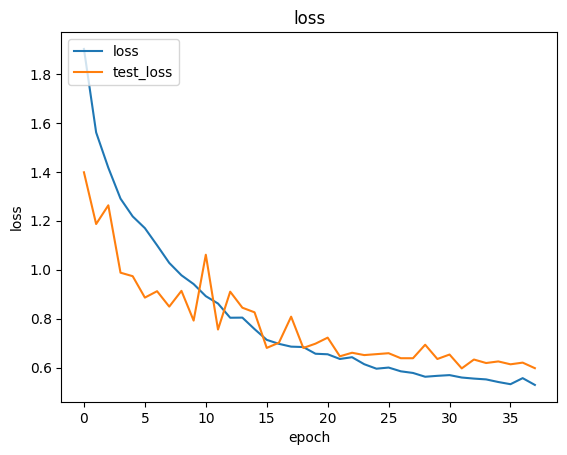

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7647 - loss: 0.7320
Test accuracy: 0.7647058963775635


In [ ]:
y_true = []
y_pred_all = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
y_true = []
y_pred_all = []
for x_batch, y_batch in val_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

scores = model.evaluate(val_ds)

print("Test accuracy:",scores[1])

In [39]:
model = CNN2D(num_classes=10, base=8)
model.build(sample_x.shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

model.evaluate(test_ds)

Epoch 1/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.3506 - loss: 1.8215 - val_accuracy: 0.5639 - val_loss: 1.2926 - learning_rate: 1.0000e-04
Epoch 2/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4546 - loss: 1.5349 - val_accuracy: 0.6416 - val_loss: 1.1125 - learning_rate: 1.0000e-04
Epoch 3/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5108 - loss: 1.3839 - val_accuracy: 0.6655 - val_loss: 1.0217 - learning_rate: 1.0000e-04
Epoch 4/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5535 - loss: 1.2738 - val_accuracy: 0.6213 - val_loss: 1.0522 - learning_rate: 1.0000e-04
Epoch 5/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5715 - loss: 1.2206 - val_accuracy: 0.6965 - val_loss: 0.9081 - learning_rate: 1.0000e-04
Epoch 6/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5987 - loss: 1.1613 - val_accuracy: 0.6464 - val_loss: 0.9011 - learning_rate: 1.0000e-04
Epoch 7/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 11s 

[0.6184728145599365, 0.8161764740943909]

              precision    recall  f1-score   support

           0     0.7200    0.5400    0.6171       100
           1     0.6977    0.9375    0.8000        32
           2     0.8108    0.9000    0.8531       100
           3     0.8953    0.7700    0.8280       100
           4     0.7500    0.6900    0.7188       100
           5     0.9125    0.8202    0.8639        89
           6     0.9118    1.0000    0.9538        31
           7     0.6698    0.8659    0.7553        82
           8     0.9643    0.9878    0.9759        82
           9     0.8571    0.9000    0.8780       100

    accuracy                         0.8162       816
   macro avg     0.8189    0.8411    0.8244       816
weighted avg     0.8200    0.8162    0.8131       816



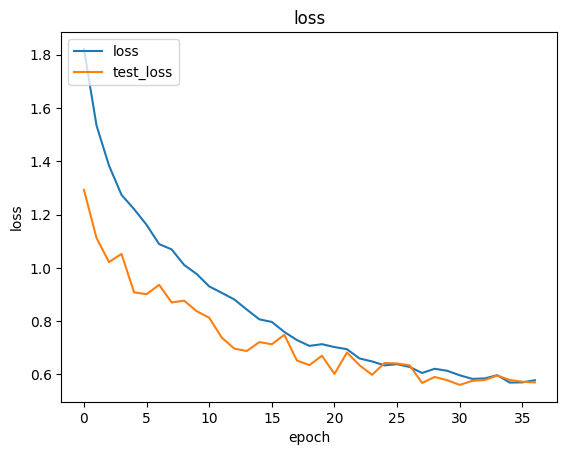

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8162 - loss: 0.6185
Test accuracy: 0.8161764740943909


In [40]:
y_true = []
y_pred_all = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [36]:
class CNN2D_Improved(tf.keras.Model):
    def __init__(self, num_classes=10, base=32):
        super().__init__()
        
        # Blocos convolucionais mais profundos
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(base, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(base, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.25)
        ])
        
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(base*2, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(base*2, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.25)
        ])
        
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(base*4, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(base*4, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(2),
            layers.Dropout(0.3)
        ])
        
        self.conv4 = tf.keras.Sequential([
            layers.Conv2D(base*8, 3, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.GlobalAveragePooling2D()
        ])
        
        # Camadas densas com regularização
        self.fc1 = layers.Dense(512, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.drop1 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(256, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.drop2 = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.conv4(x, training=training)
        x = self.fc1(x)
        x = self.drop1(x, training=training)
        x = self.fc2(x)
        x = self.drop2(x, training=training)
        return self.out(x)

In [ ]:
model = CNN2D_Improved(num_classes=10, base=8)
model.build(sample_x.shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=16,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

model.evaluate(test_ds)

Epoch 1/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.3070 - loss: 2.1495 - val_accuracy: 0.3166 - val_loss: 2.0754 - learning_rate: 2.0000e-04
Epoch 2/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4032 - loss: 1.8245 - val_accuracy: 0.3919 - val_loss: 2.0429 - learning_rate: 2.0000e-04
Epoch 3/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4446 - loss: 1.6916 - val_accuracy: 0.3931 - val_loss: 1.8288 - learning_rate: 2.0000e-04
Epoch 4/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4888 - loss: 1.5826 - val_accuracy: 0.3584 - val_loss: 2.0631 - learning_rate: 2.0000e-04
Epoch 5/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5094 - loss: 1.4968 - val_accuracy: 0.4170 - val_loss: 1.8707 - learning_rate: 2.0000e-04
Epoch 6/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5491 - loss: 1.3958 - val_accuracy: 0.4421 - val_loss: 1.8052 - learning_rate: 2.0000e-04
Epoch 7/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 12s

[1.2877496480941772, 0.5992646813392639]

In [ ]:
y_true = []
y_pred_all = []

for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_pred_batch = model.predict(x_batch, verbose=0)
    y_pred_all.extend(np.argmax(y_pred_batch, axis=1))

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)
print(classification_report(y_true, y_pred_all, digits=4))

# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
# ...existing code...
class CNN1D_fixed(tf.keras.Model):
    def __init__(self, input_shape=(16000,1), num_classes=10, hidden_layers=5, kernel_size=9):
        super().__init__()
        self.blocks = []
        # bloco 1
        filters = 16
        self.blocks.append(tf.keras.Sequential([
            layers.Conv1D(filters, kernel_size, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=4)
        ]))
        # blocos intermediários
        for i in range(1, hidden_layers-1):
            filters = 16 * (2**i)
            self.blocks.append(tf.keras.Sequential([
                layers.Conv1D(filters, kernel_size, padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling1D(pool_size=4)
            ]))
        # conv final (mantém dimensionalidade temporal)
        final_filters = 16 * (2**(hidden_layers-1))
        self.conv_last = layers.Conv1D(final_filters, kernel_size, padding='same', activation='relu')
        self.bn_last = layers.BatchNormalization()
        self.global_pool = layers.GlobalAveragePooling1D()
        # densas
        fc_units = 16 * (2**hidden_layers)
        self.fc1 = layers.Dense(fc_units, activation='relu')
        self.drop = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = inputs
        for blk in self.blocks:
            x = blk(x, training=training)
        x = self.conv_last(x)
        x = self.bn_last(x, training=training)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.drop(x, training=training)
        return self.out(x)

class CNN2D_matched(tf.keras.Model):
    def __init__(self, input_shape=(64, 157, 1), num_classes=10, base_filters=8):
        super().__init__()
        # arquitetura 2D com profundidade similar em parâmetros
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(base_filters, (3,3), padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2,2))
        ])
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(base_filters*2, (3,3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2,2))
        ])
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(base_filters*4, (3,3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2,2))
        ])
        
        self.conv_last = tf.keras.Sequential([
            layers.Conv2D(base_filters*2, (3,3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D()
        ])
        # densas alinhadas ao modelo 1D
        fc_units = base_filters*32  # 16 * 2**5 = 512 quando base_filters=16
        self.fc1 = layers.Dense(fc_units, activation='relu')
        self.drop = layers.Dropout(0.4)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.conv_last(x, training=training)
        x = self.fc1(x)
        x = self.drop(x, training=training)
        return self.out(x)

# utilitário rápido para comparar contagem de parâmetros
def params_count(model, example_input_shape):
    m = model
    m.build((None,)+example_input_shape)
    return m.count_params()

# exemplo de uso (instancie e veja parâmetros)
#cnn1 = CNN1D_fixed(input_shape=(16000,1))
#cnn2 = CNN2D_matched(input_shape=(64,157,1))  # 64 mel bins × ~157 frames para 1s@16000 com hop≈100
#print("CNN1D params:", params_count(cnn1, (16000,1)))
#print("CNN2D params:", params_count(cnn2, (64,157,1)))
# ...existing code...

In [ ]:
import glob

class FoldDatasetBuilder:
    def __init__(self, base_path, val_fold=10, test_fold=9, batch_size=16):
        self.base_path = base_path
        self.val_fold = val_fold
        self.test_fold = test_fold
        self.batch_size = batch_size
        
    def get_files_by_fold(self, fold):
        pattern = os.path.join(self.base_path, f"fold{fold}_*.npz")
        return sorted(glob.glob(pattern))
    
    def build_datasets(self):
        # Treino: todos os folds exceto val e test
        train_files = []
        for fold in range(1, 11):
            if fold not in [self.val_fold, self.test_fold]:
                train_files.extend(self.get_files_by_fold(fold))
        
        val_files = self.get_files_by_fold(self.val_fold)
        test_files = self.get_files_by_fold(self.test_fold)
        
        print(f"Configuração: Val=fold{self.val_fold}, Test=fold{self.test_fold}")
        print(f"Train: {len(train_files)} ficheiros")
        print(f"Val:   {len(val_files)} ficheiros")
        print(f"Test:  {len(test_files)} ficheiros")
        
        train_ds = make_ds(train_files, batch=self.batch_size, shuffle=True)
        val_ds = make_ds(val_files, batch=self.batch_size, shuffle=False)
        test_ds = make_ds(test_files, batch=self.batch_size, shuffle=False)
        
        return train_ds, val_ds, test_ds

# Uso:
builder = FoldDatasetBuilder(
    base_path="./precomputed_mels",
    val_fold=10,
    test_fold=9,
    batch_size=16
)

train_ds, val_ds, test_ds = builder.build_datasets()

In [ ]:
def k_fold_cross_validation(base_path, k=10, batch_size=16):
    """
    Treina modelo em K-Fold cross-validation
    """
    results = []
    
    for test_fold in range(1, k+1):
        val_fold = (test_fold % k) + 1  # fold seguinte para validação
        
        print(f"\n{'='*50}")
        print(f"Fold {test_fold}/{k}: Test=fold{test_fold}, Val=fold{val_fold}")
        print(f"{'='*50}")
        
        train_ds = make_ds(train_files, batch=4, shuffle=True)
        val_ds   = make_ds(val_files, batch=4, shuffle=False)
        test_ds  = make_ds(test_files, batch=4, shuffle=False)
        
        # Treinar modelo
        tf.keras.backend.clear_session()
        model = CNN2D_Improved(num_classes=10, base=16)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=50,
            batch_size=batch_size,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
            ],
            verbose=1
        )
        
        # Avaliar no test set
        test_loss, test_acc = model.evaluate(test_ds)
        results.append({
            'fold': test_fold,
            'test_acc': test_acc,
            'test_loss': test_loss
        })
        
        print(f"Fold {test_fold} - Test Accuracy: {test_acc:.4f}")
    
    # Resultados finais
    avg_acc = np.mean([r['test_acc'] for r in results])
    std_acc = np.std([r['test_acc'] for r in results])
    
    print(f"\n{'='*50}")
    print(f"Resultados K-Fold ({k} folds):")
    print(f"Accuracy Média: {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"{'='*50}")
    
    return results

# Executar K-Fold
results = k_fold_cross_validation("./precomputed_mels", k=10, batch_size=32)


Fold 1/10: Test=fold1, Val=fold2
Epoch 1/50


2025-11-27 09:48:17.332661: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2951', 8 bytes spill stores, 8 bytes spill loads



1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2154 - loss: 2.5175

2025-11-27 09:49:22.191259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2951', 8 bytes spill stores, 8 bytes spill loads



2025-11-26 23:27:15.709795: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0     0.4400    0.2200    0.2933       100
           1     0.7714    0.8438    0.8060        32
           2     0.8763    0.8500    0.8629       100
           3     0.6667    0.7200    0.6923       100
           4     0.7534    0.5500    0.6358       100
           5     0.5915    0.9438    0.7273        89
           6     0.9355    0.9355    0.9355        31
           7     0.6630    0.7439    0.7011        82
           8     0.8202    0.8902    0.8538        82
           9     0.8586    0.8500    0.8543       100

    accuracy                         0.7267       816
   macro avg     0.7377    0.7547    0.7362       816
weighted avg     0.7199    0.7267    0.7119       816



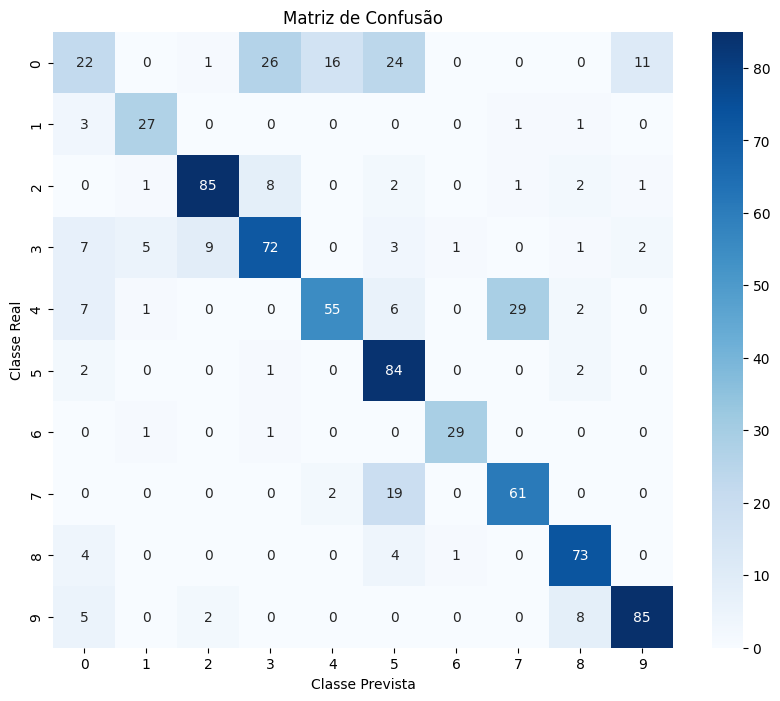

In [ ]:
# Matriz de confusão (opcional)
cm = confusion_matrix(y_true, y_pred_all)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

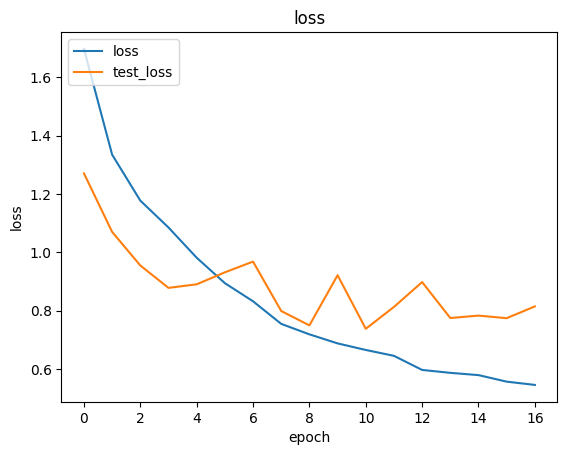

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7267 - loss: 0.8050
Test accuracy: 0.7267156839370728


In [13]:
# plot training history

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['loss','test_loss'], loc='upper left')

plt.show()

# Evaluate the model

scores = model.evaluate(test_ds)

print("Test accuracy:",scores[1])

In [ ]:
"""model = CNN1D_fixed(input_shape=X_train.shape[2:], num_classes=10)

# Compilar
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=32,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
          ])"""

In [ ]:
"""y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Relatório detalhado
print(classification_report(y_test, y_pred_classes, digits=4))"""